## Семинар 9: "LSTM"

ФИО: Зеленцов Алексей Викторович

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [359]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = torch.autograd.Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

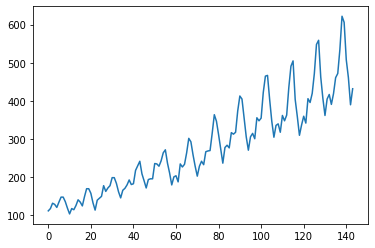

In [360]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [361]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [399]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [400]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [661]:
# Пример подготовленных данных

look_back = 10
look_forward=2
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [662]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))

In [663]:
train_dataloader =  DataLoader(train_dataset, batch_size=5)

In [664]:
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))

In [665]:
test_dataloader = DataLoader(test_dataset, batch_size=5)

In [666]:
hidden_size = look_forward

In [667]:
my_model = LSTM(input_size=look_back, hidden_size=hidden_size)
model = torch.nn.LSTM(input_size=look_back, hidden_size=hidden_size)

In [668]:
def train_model(model, epochs=100):
    criterion = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        hidden = (torch.zeros(1, 1, hidden_size),
                  torch.ones(1, 1, hidden_size))
        model.zero_grad()
        for x, y in train_dataloader:
            Y_pred, hidden = model(x, hidden)
        loss = criterion(y, Y_pred.view(*y.size()))
        if (epoch + 1) % 50 == 0:
            print(f'\repoch {epoch + 1}: loss {loss.item()}', end='')
        loss.backward()
        optimizer.step()

In [669]:
def eval_model(model):
    hidden = (torch.zeros(1, 1, hidden_size),
              torch.ones(1, 1, hidden_size))
    model.zero_grad()
    loss = 0
    counts = 0
    for x, y in test_dataloader:
        predY, hidden = model(x, hidden)

        loss_batch = criterion(y, predY.view(*y.size()))
        loss += loss_batch.item()
        counts += 1
    print(f'result : {loss/counts}')

In [670]:
train_model(model, 1000)

epoch 1000: loss 0.004477391485124826

In [671]:
eval_model(model)

result : 0.05706995126924345


In [672]:
train_model(my_model, 1000)

epoch 1000: loss 0.003009562613442546

In [673]:
eval_model(my_model)

result : 0.04142166667484811


In [674]:
def return_predicted(model):
    hidden = (torch.zeros(1, 1, hidden_size),
              torch.zeros(1, 1, hidden_size))
    predicted = []
    model.zero_grad()
    for x, y in test_dataloader:
        predY, hidden = model(x, hidden)
        predicted += list(predY[:, 0, 0])
    return predicted

In [675]:
def plot_model(model, ovr):
    pred = return_predicted(model)
    pred = [i.item() for i in pred]
    ovr[-len(pred):] = pred
    plt.plot(ovr)

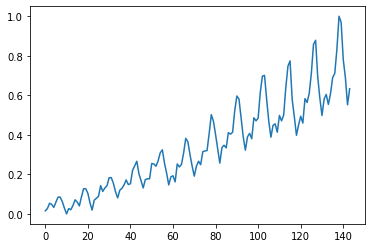

In [676]:
ovr = np.hstack((train[:, 0], test[:, 0]))
plt.plot(ovr)

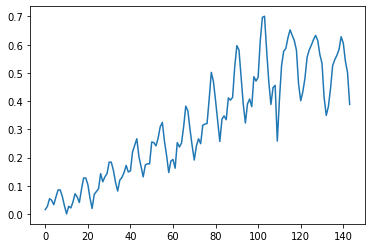

In [677]:
plot_model(model, ovr)

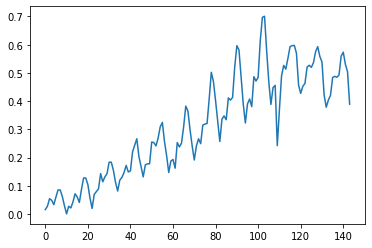

In [678]:
plot_model(my_model, ovr)

Что-то более-менее похожее на правду получилось при длинах входной и выходной последовательности 10 и 2 соответственно

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: